In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import AsinhStretch, ImageNormalize
from analysis_utils import plot_2D_map, imfit_wrapper, get_projected_coord, get_radec_coord, calc_radial_profile
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
prefix = "/raid/work/yamato/eDisk_data/L1489IRS/v0_images/continuum/L1489IRS_SBLB_continuum_"
imaging_param = "robust_1.0_taper_3000klambda"
ext = ".pbcor.tt0.fits"

imagepath = prefix + imaging_param + ext

# image cutout for plot
cutout = (slice(2100, 3900), slice(2100,3900))

# plot parameters
norm = ImageNormalize(fits.getdata(imagepath)[cutout], vmin=0.0, stretch=AsinhStretch(a=0.03))
imshow_kw = pcolorfast_kw = {'cmap': 'inferno', 'norm': norm}
contour_kw = {"colors": "white", "linewidths": 0.2, "linestyles": "dashed"}

In [3]:

# nominal source position
common_dir = "04h04m43.070001s +26d18m56.20011s" # from imaging script

# mask setup 
mask_ra = common_dir.split()[0].replace("h", ":").replace("m", ":").replace("s", "")
mask_dec = common_dir.split()[1].replace("d", ".").replace("m", ".").replace("s", "")
mask_pa = 0.0  # position angle of mask in degrees
mask_maj = 5.0  # semimajor axis of mask in arcsec
mask_min = 5.0  # semiminor axis of mask in arcsec
common_mask = "ellipse[[%s, %s], [%.1farcsec, %.1farcsec], %.1fdeg]" % (mask_ra, mask_dec, mask_maj, mask_min, mask_pa)

# set the initial estimates file
# peak intensity, peak xpixel, peak ypixel, maj, min, pa
# values from Sai et al. 2020
est_str_list = [
    "0.003, 3000, 3000, 0.097arcsec, 0.037arcsec, 49deg\n",
    "0.001, 3000, 3000, 4.1arcsec, 1.2arcsec, 69deg\n",
]  # need \n
estimates_filename = "./L1489IRS_cont_imfit.estimates"
with open(estimates_filename, "w") as f:
    f.writelines(est_str_list)

# set model and residual file
mod_filename = "./L1489IRS_cont_imfit.model.image"
res_filename = "./L1489IRS_cont_imfit.residual.image"

# import the statistics
stat_file = "./L1489IRS_cont_statistics.pkl"
stat = pd.read_pickle(stat_file)
rms = stat.loc[imaging_param, "rms [mJy / beam]"] * 1e-3 # in Jy / beam


Start fitting 2D Gaussian to /raid/work/yamato/eDisk_data/L1489IRS/v0_images/continuum/L1489IRS_SBLB_continuum_robust_1.0_taper_3000klambda.pbcor.tt0.fits...
Done!
Fit converged!
{'component0': {'flux': <Quantity 0.00462234 Jy>,
                'flux_error': <Quantity 3.7606719e-05 Jy>,
                'inclination': <Quantity 47.10298804 deg>,
                'ispoint': True,
                'peak': <SkyCoord (ICRS): (ra, dec) in deg
    (61.17945693, 26.31561477)>,
                'peak_intensity': <Quantity 0.00450212 Jy / beam>,
                'peak_intensity_error': <Quantity 2.08370583e-05 Jy / beam>,
                'size': {'maj': <Quantity 0.09584938 arcsec>,
                         'min': <Quantity 0.06524301 arcsec>,
                         'pa': <Quantity 25.58457531 deg>}},
 'component1': {'flux': <Quantity 0.04366721 Jy>,
                'flux_error': <Quantity 0.0011899 Jy>,
                'inclination': <Quantity 75.92502286 deg>,
                'ispoint': False,
 

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


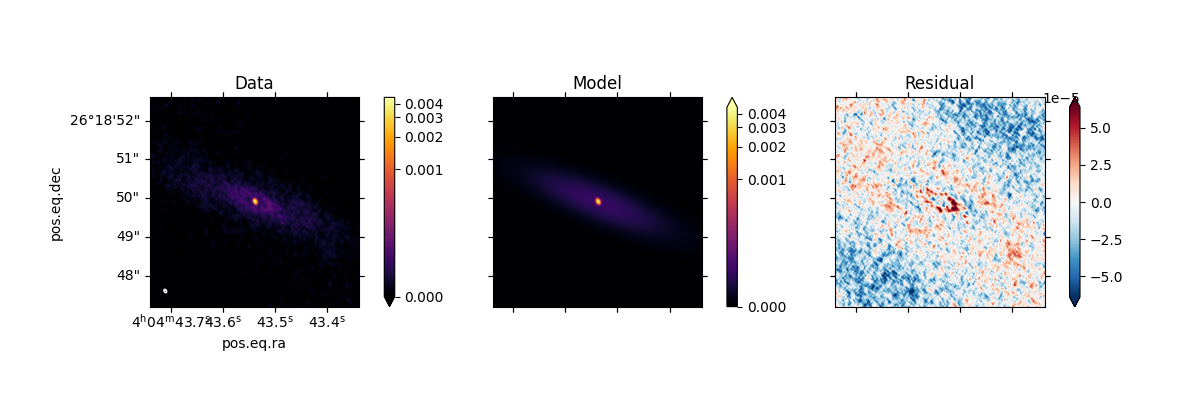

In [5]:
# 2 component Gaussian fit
result = imfit_wrapper(
    imagepath,
    region=common_mask,
    model=mod_filename,
    residual=res_filename,
    estimates=estimates_filename,
    rms=rms,
    plot=True,
    plot_region_slices=cutout,
    plot_kw={'imshow_kw': imshow_kw},
)


In [5]:
# save the result
import pickle
savefile = "./L1489IRS_cont_imfit.result.pkl"
with open(savefile, 'wb') as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# image analysis

import pickle
savefile = "./L1489IRS_cont_imfit.result.pkl"
with open(savefile, 'rb') as f:
    result = pickle.load(f)

header = fits.getheader(imagepath)
data = fits.getdata(imagepath)

beam = (header['BMAJ']*3600, header['BMIN']*3600, 90 - header['BPA']) # in arcsec
scale = (50. / 140., '50 au') #in arcsec

# source center coordinate from Gaussian fit
center_coord = result['component0']['peak']
#center_coord = SkyCoord(common_dir, frame='icrs')

x, y = get_radec_coord(header, center_coord=center_coord)

[Text(0.5, 0, '$\\Delta\\alpha\\cos(\\delta)$ [arcsec]'),
 Text(0, 0.5, '$\\Delta\\delta$ [arcsec]')]

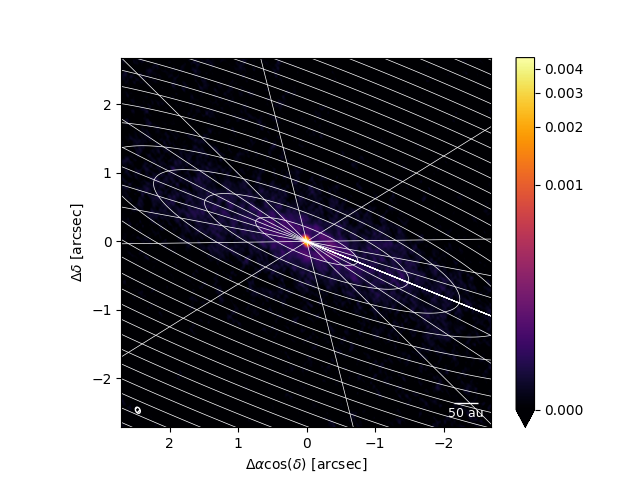

In [7]:
# calculate radial profile
r, theta = get_projected_coord(header, PA=68, incl=76, center_coord=center_coord, which='polar')

# overplot the coordinate
fig, ax = plt.subplots()
plot_2D_map(data[cutout], X=x[cutout[0]], Y=y[cutout[1]], ax=ax, contour=False, beam=beam, scale=scale, pcolorfast_kw={'norm': norm, 'cmap': 'inferno'})
ax.contour(x[cutout[0]], y[cutout[1]], r[cutout], levels=20, colors='white', linewidths=0.5)
ax.contour(x[cutout[0]], y[cutout[1]], theta[cutout], levels=20, colors='white', linestyles='solid', linewidths=0.5)
ax.set(xlabel=r'$\Delta\alpha\cos(\delta)$ [arcsec]', ylabel='$\Delta\delta$ [arcsec]')


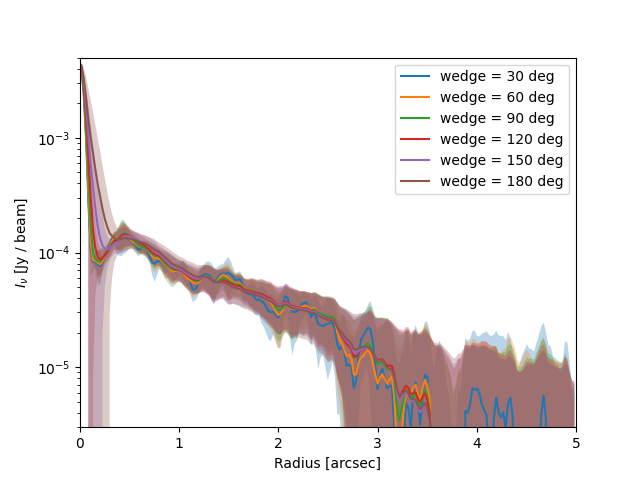

In [8]:
# check the theta exclusion dependence
PA = result['component1']['size']['pa'].value
incl = result['component1']['inclination'].value
rmax = 5.0 # outer boundary of calculation region
rbins = np.arange(header['BMAJ'] * 3600 * 0.25 * 0.5, rmax, header['BMAJ'] * 3600 * 0.25)
include_theta = [30., 60., 90, 120., 150., 180.]

fig, ax = plt.subplots()
for t in include_theta:
    _, radprof, radprof_scatter = calc_radial_profile(header, data, PA=PA, incl=incl, center_coord=center_coord, rbins=rbins, include_theta=t)
    
    ax.plot(rbins, radprof, label='wedge = {:.0f} deg'.format(t))
    ax.fill_between(rbins, radprof-radprof_scatter, radprof + radprof_scatter, alpha=0.3)

    ax.axhline(y=0.0, color='grey', ls='dashed')
    ax.set(xlim=(0,rmax), xlabel='Radius [arcsec]', ylabel=r'$I_{\nu}$ [Jy / beam]', yscale='log', ylim=(3e-6, 5e-3))
ax.legend()

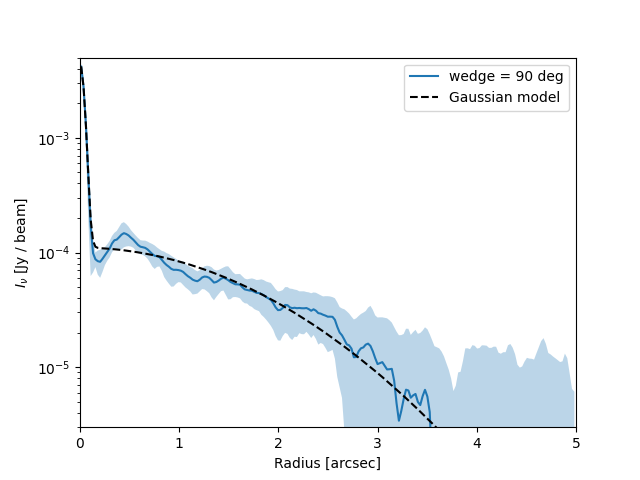

In [12]:
# comparison with Gaussian model 
include_theta = 90.
_, radprof, radprof_scatter = calc_radial_profile(header, data, PA=PA, incl=incl, center_coord=center_coord, rbins=rbins, include_theta=include_theta)

# model
mod_hdr = fits.getheader(mod_filename + '.fits')
mod_data = fits.getdata(mod_filename + '.fits')
_, rp_mod, rp_mod_scatter = calc_radial_profile(mod_hdr, mod_data, PA=PA, incl=incl, center_coord=center_coord, rbins=rbins, include_theta=include_theta)


fig, ax = plt.subplots()
ax.plot(rbins, radprof, label='wedge = {:.0f} deg'.format(include_theta))
ax.fill_between(rbins, radprof-radprof_scatter, radprof + radprof_scatter, alpha=0.3)
ax.plot(rbins, rp_mod, label='Gaussian model', ls='dashed', color='black')
ax.axhline(y=0.0, color='grey', ls='dashed')
ax.set(xlim=(0,rmax), xlabel='Radius [arcsec]', ylabel=r'$I_{\nu}$ [Jy / beam]', yscale='log', ylim=(3e-6, 5e-3))
ax.legend()

In [19]:
import astropy.constants as ac
from astropy.modeling import models
nu0 = 234 * u.GHz
f = (43.7+4.62) * u.mJy 
d = 140 * u.pc 
kappa = 0.023 * u.g / u.cm**2
T_d = 25 * u.K 
bb = models.BlackBody(temperature=T_d)
M = f * d ** 2 / kappa / bb(nu0)
print(M.decompose())

1.1767997131870745e+26 m4 rad2 / kg


In [ ]:
(4 * u.mJy/u.beam).to(u.K, equevalencies=u.brightness_temperature(nu0, ))